# Music Genre Classification with Deep Learning

For over 25 years I've been playing guitar. Music is one of my greatest passions. I play music of any genre from jazz, blues, rock and pop to heavy metal. All of these genres are easy to recognize to a human ear (well for the most part... some bands are crossing genre boundaries, but we'll leave it be for now), but can a machine learn how to understand them? I decided to take it as a challenge.

## Problem

The problem I'm going to attempt solving is the problem of classification of music into genres by a deep learning model analysing the sound waves. The model will have to learn intrinsinc patterns of sound waves and classify them into genres. It feels to me that this is the perfect problem for deep learning!

## Approach

I'll take a dual approach:

1.   **Multilayer perceptron**. I will train a simple Multilayer perceptron using extracted numerical features (Tempo, Spectral Centroid, Zero Crossing Rate).
2.   **Convolutional Neural Network**. I will use the image representation of the sound spectrum of each genre sample to train a CNN recognizing the genre.

Subsequently, I'm going to optimize the model, find the most effective configuration and compare their effectiveness.


### Dataset

I'm using [the GTZAN Genre Classification dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data) from Kaggle, which is widely considered to be the standard for any music classification projects (although it's sometimes criticized as dated and relativelly limited).

The dataset consists of 1,000 audio tracks (100 tracks per 10 genres: Blues, Classical, Country, Disco, Hiphop, Jazz, Metal, Pop, Reggae, and Rock) each 30 seconds long and corresponding image files with mel spectograms.

The audio files are .wav format, sampled at 22,050Hz. The dataset also includes a CSV file with extracted mathematical features (like RMS level and Tempo).

The important thing to understand (I will use it across subsequent sections) is what the features in the CSV file represent. I pull them from the original paper and organized in tables:

##### Timbral Features (Texture & Color)
These features capture the "color" or quality of the sound, independent of pitch or rhythm. They are crucial for distinguishing between instruments (e.g., a distorted guitar vs. a piano).

| Feature Name | Technical description | Musical description |
| :--- | :--- | :--- |
| **`mfcc`** (1-20) | **Mel-Frequency Cepstral Coefficients**. <br>  A representation of the short-term power spectrum, <br> approximating the human ear's response. | Metal has sharp, distorted MFCCs; Pop has smooth, <br>consistent MFCCs. This is often the single most important<br> feature for classification. |
| **`rms_mean`** | **Root Mean Square**. The square root of the mean <br>squared amplitude. Measures signal energy. |Compressed genres (Metal/Disco) have high, consistent <br>RMS (the "brick wall" effect). Dynamic genres (Classical) <br>have low mean RMS with high variance. |
| **`zero_crossing_rate`** | The rate at which the signal changes sign (positive/negative). |High values indicate noisy signals (percussion, distortion).<br> Low values indicate smooth signals (strings, vocals). |

##### Spectral Features (Frequency Shape)
These features describe the distribution of energy across the frequency spectrum (low vs. high frequencies).

| Feature Name | Technical Description | Musical description |
| :--- | :--- | :--- |
| **`spectral_centroid`** | The "center of mass" of the spectrum (weighted mean of <br>frequencies). | High values indicate "Bright" sounds (cymbals, distortion). <br>Low values indicate "Dark" sounds (bass, cello). |
| **`rolloff_mean`** | The frequency below which 85% of the total spectral energy <br>lies. | Distinguishes bass-heavy genres (Hiphop, Reggae) from <br>treble-heavy genres (Pop, Disco). |
| **`spectral_bandwidth`** | The width of the spectral band at half the maximum amplitude. |Wide bandwidth suggests complex, full-spectrum sound<br> (Orchestra). Narrow bandwidth suggests simple, focused sound <br>(Solo Instrument). |

##### Rhythmic & Harmonic Features
These features analyze the temporal structure (time) and tonal structure (pitch).

| Feature Name | Technical Description | Musical description |
| :--- | :--- | :--- |
| **`tempo`** | Estimated **Beats Per Minute (BPM)** derived from onset detection. | Separates fast genres (Drum & Bass, Metal) from slower ones <br>(Blues, Country). |
| **`chroma_stft_mean`** | Energy distribution across the 12 pitch classes (C, C#, D, etc.) <br>regardless of octave. | Captures harmonic complexity. Useful for distinguishing tonal <br>music (Jazz) from rhythmic-focused music (Hiphop). |
| **`harmony_mean`** | The harmonic component separated from the audio signal. | The "tune" of the track, separating sustained instruments<br> from drums. |
| **`perceptr_mean`** | The percussive component separated from the audio signal. | The "beat" of the track, isolating drums and transients. |

## Potential practical application of the model

Music classification algorithms are used by servises such as YouTube Music, Spotify or Apple Music to help with the user discovery experience. Having a model able to classify genres could also be the foundation for all sorts of AI music tools (e.g. track separation for specific genres).

## Reference
Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. IEEE Transactions on speech and audio processing, 10(5), 293-302.

## Data preparation

The first step is to actually get the datset. I decided to run the project on collab to get extra compute resources for the CNN training (I had in the past pretty bad experiences with local training for CNNs that lasted over a day, so I'm trying to avoid a repeat), so my first step is to download the dataset to Colab.

First, I'm going to get value for the API key and the username from Colab's secrets.

Then I'm going to dynamically compose .json file required by Kaggle's API and download the data directly to the colab environment.

In [3]:
import os
from google.colab import userdata

# getting and storing kaggle API username and key
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')

In [4]:
import json

# composing kaggle json file to pass it to the Kaggle API and download the data
kaggle_dir = '/root/.kaggle'
os.makedirs(kaggle_dir, exist_ok=True)

api_token = {"username": kaggle_username, "key": kaggle_key}

with open(os.path.join(kaggle_dir, 'kaggle.json'), 'w') as f:
    json.dump(api_token, f)

# Setting the secure file permissions
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Downloading the dataset

!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 90% 1.09G/1.21G [00:06<00:01, 65.9MB/s]
100% 1.21G/1.21G [00:06<00:00, 187MB/s] 


## Exploratory Data Analysis

As I mentioned before the dataset that we're dealing with has an interesting, diverse, structure and consists of audio files, spectrogram images and a csv file with numerical metadata. In the EAD I'm going to analyze all three and see if I need to think about a data clean up and augomentation. I'm going to perform:

1. **Metadata Analysis** (CSV): Proving the dataset is balanced and identifying useful mathematical features.

2. **Audio Signal Analysis** (Wav): Visualizing the raw sound to show time-domain differences.

3. **Spectral Analysis** (Spectrograms): Visualizing the frequency domain to verify our Deep Learning approach.

## Metadata analysis

First, I'm going to look into the CSV file and metadata and I'll:
*   Investigate the data structure and perform any necessary quick cleanups
*   Check the balance between genres
*   Check if any features can be eliminated by exploring their correlation
*   Check the distribution of values in the main features



          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

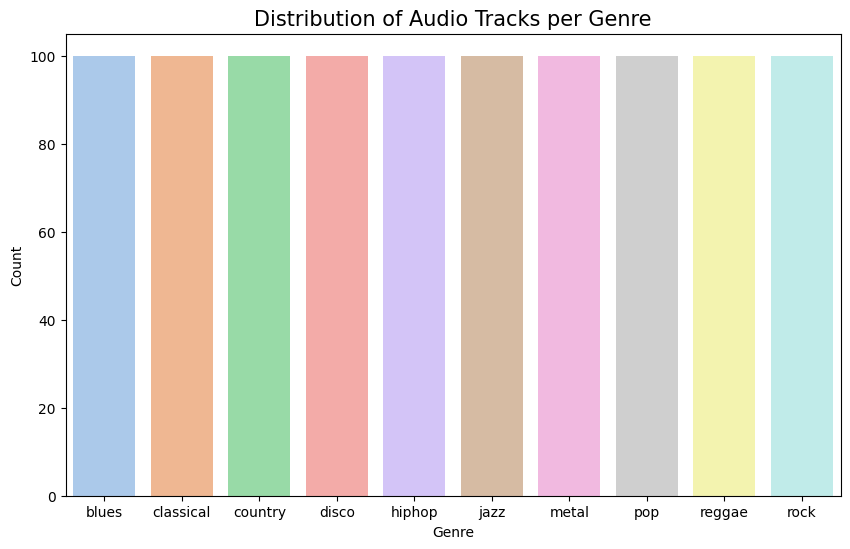

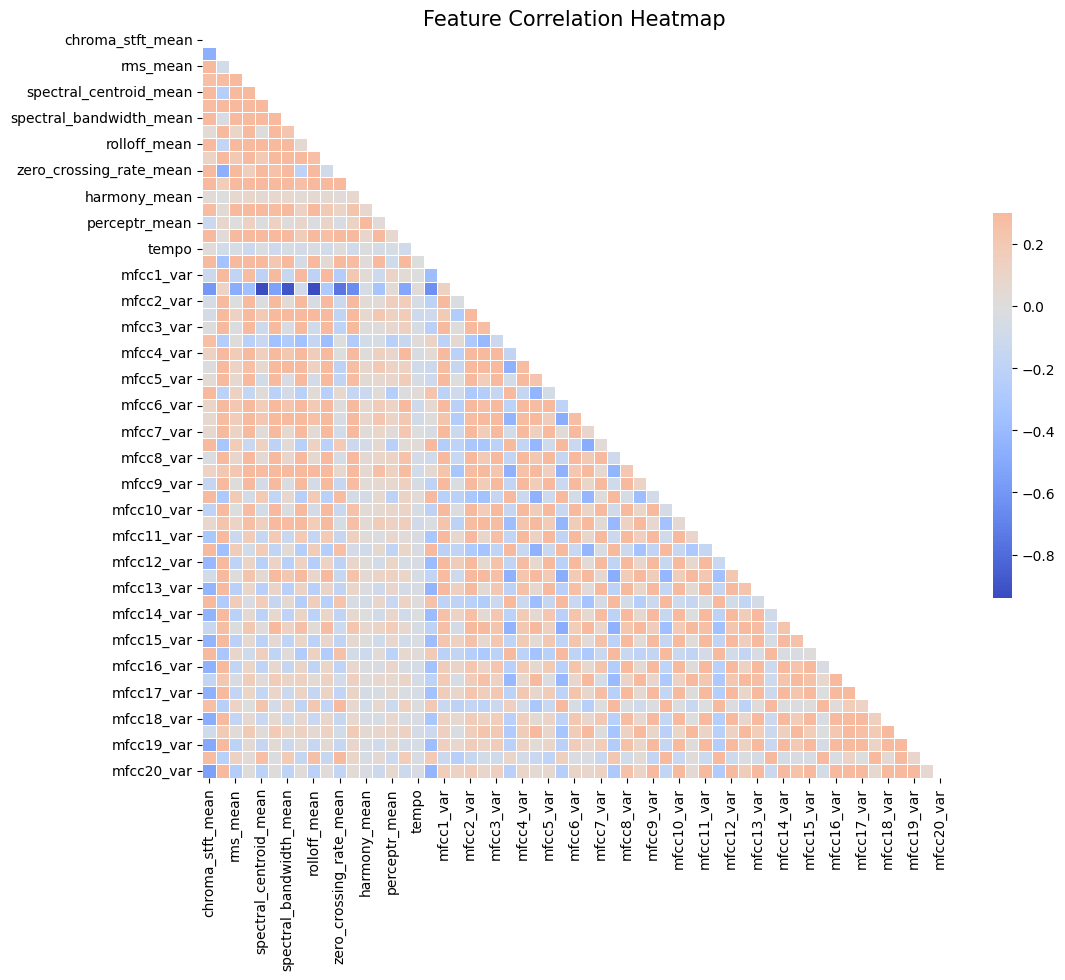

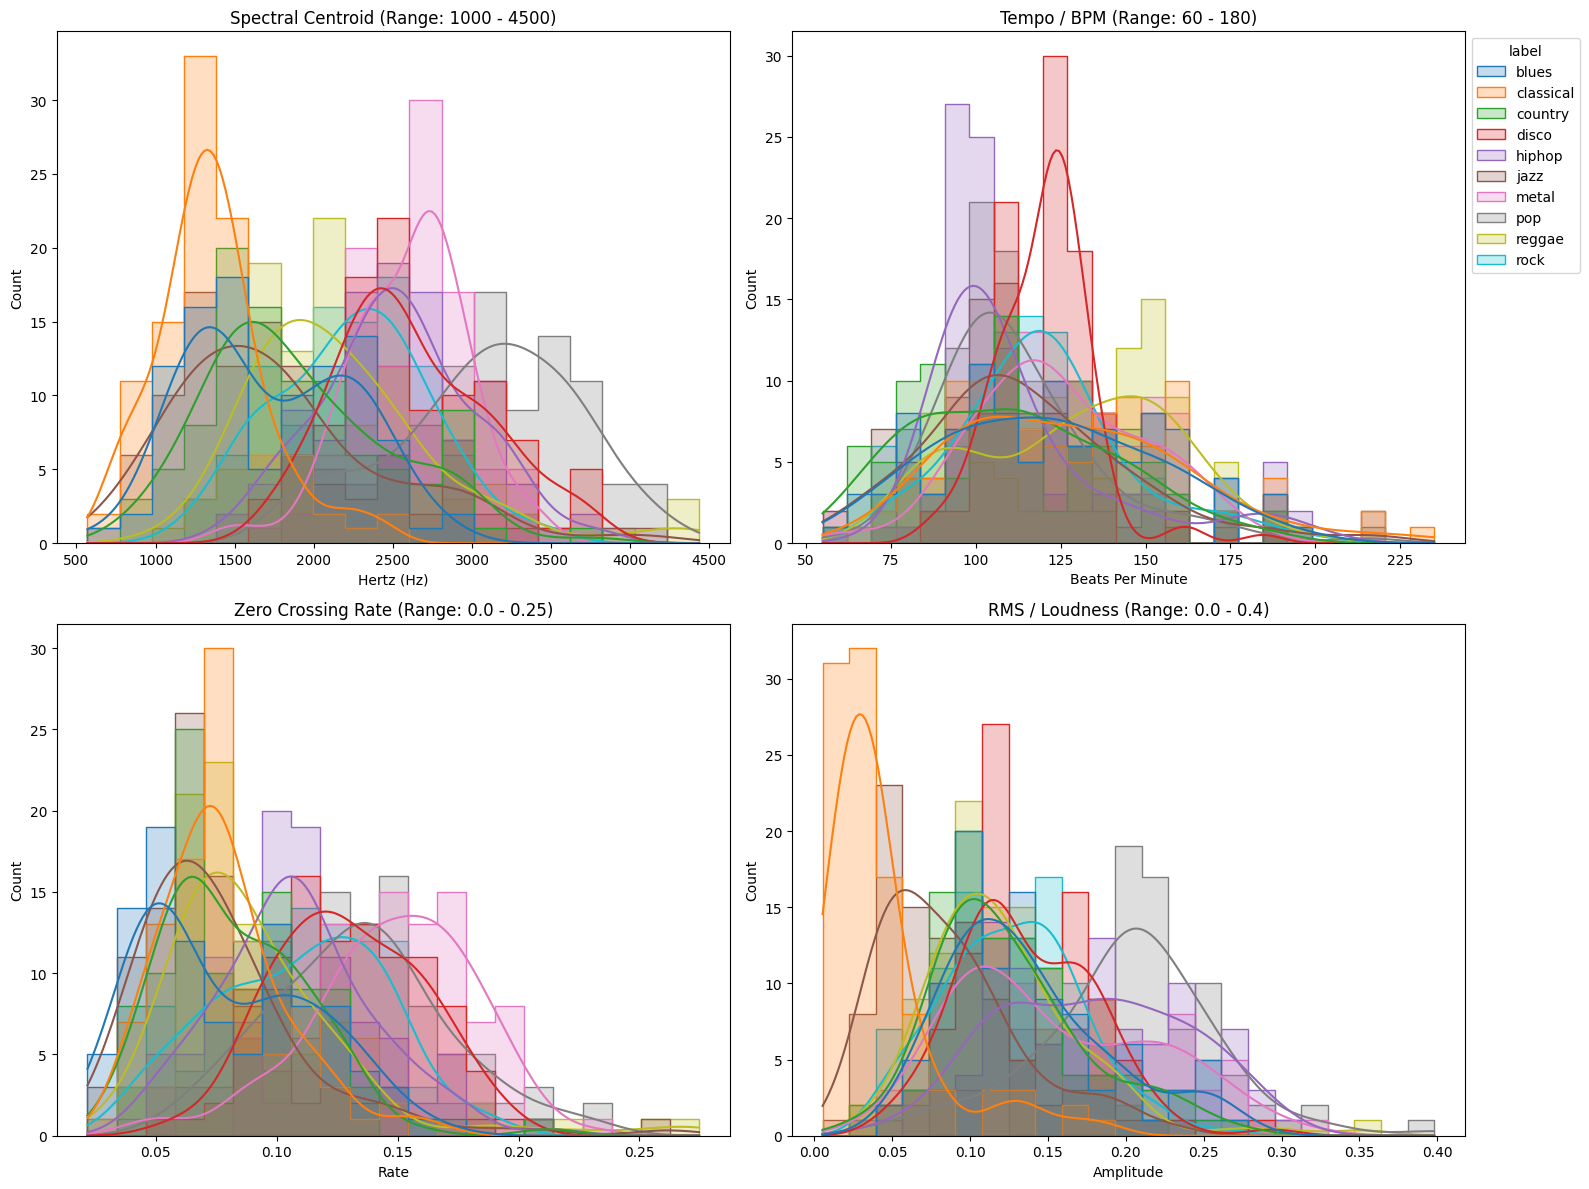

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the CSV file
csv_path = 'Data/features_30_sec.csv'
df = pd.read_csv(csv_path)
print(df.head(5))

# Cleaning data.
# Based on head() I noticed that legnth is completely redundant
# (all files have the same length) and filename and label will
# have to be dropped for the correlation analysis. I'm starting
# a new df with just the numerical data
numeric_df = df.drop(['filename', 'length', 'label'], axis=1)

# Balance of classes. First analysis is a simple count of samples per genre
plt.figure(figsize=(10, 6))
sns.countplot(x=df['label'], hue=df['label'], legend=False, palette='pastel')
plt.title('Distribution of Audio Tracks per Genre', fontsize=15)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# Correlation of features. Second, I'm checking how correlated are the features.
plt.figure(figsize=(12, 10))
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap', fontsize=15)
plt.show()

# Finally, I'm plotting the distribution of values across the main features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Spectral Centroid
sns.histplot(data=df, x='spectral_centroid_mean', hue='label', kde=True, element="step", ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Spectral Centroid (Range: 1000 - 4500)')
axes[0, 0].set_xlabel('Hertz (Hz)')

# Tempo / BPM
sns.histplot(data=df, x='tempo', hue='label', kde=True, element="step", ax=axes[0, 1]) # Legend stays here
axes[0, 1].set_title('Tempo / BPM (Range: 60 - 180)')
axes[0, 1].set_xlabel('Beats Per Minute')
# Move legend outside to keep it clean
sns.move_legend(axes[0, 1], "upper left", bbox_to_anchor=(1, 1))

# Zero Crossing Rate
sns.histplot(data=df, x='zero_crossing_rate_mean', hue='label', kde=True, element="step", ax=axes[1, 0], legend=False)
axes[1, 0].set_title('Zero Crossing Rate (Range: 0.0 - 0.25)')
axes[1, 0].set_xlabel('Rate')

# RMS / Loudness
sns.histplot(data=df, x='rms_mean', hue='label', kde=True, element="step", ax=axes[1, 1], legend=False)
axes[1, 1].set_title('RMS / Loudness (Range: 0.0 - 0.4)')
axes[1, 1].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()

### Changes after the metadata analysis

1. **Feature correlation heatmap**
There's a fair amount of correlation between different features e.g. specral_centroid_mean, spectral_bandwidth_mean and rolloff_mean. While this at first caused my concern, I think I understand where this is comign from - a brighter sound (high centroid) will have more high frequencies (high rolloff).
Since our main model is going to be based on deep learning I think I can keep these features and the model will find the useful. Interestingly there's also a feature which is higly uncorrelated - mfcc2_var (energy in low vs. high frequencies). A negative correlation means that as the sound gets "brighter" (more spectral centroid), the variance in this specific coefficient drops. This is a strong signal that will help the model distinguish genres.

2. **Feature range visualization**
The last EAD analysis shows a few inreesting things. Some of the features (RMS/Loudness) show a significant difference between genres. This will help the model distinguish between them! One thing however draw my attention - the actual numeric values are hugely different! Spectral centroid operates in thousands, while amplitutde in fractions. The data need to get normalized before feeding it into training.

## Waveform visualization

Next I'm going to visualize the waveform for all ten genres to visually inspect whether they look different.

I'm using an interesting library for audio analysis called Librosa. Librosa let me show the waveform for each loaded file.

#### Reference
McFee, B., Raffel, C., Liang, D., Ellis, D. P., McVicar, M., Battenberg, E., & Nieto, O. (2015). **librosa: Audio and music signal analysis in python**. *Proceedings of the 14th Python in Science Conference*, 8, 18-25. doi:10.25080/Majora-7b98e3ed-003

McFee, B., et al. (2024). *Librosa 0.10.2 Documentation*. Retrieved from [https://librosa.org/doc/latest/index.html](https://librosa.org/doc/latest/index.html)

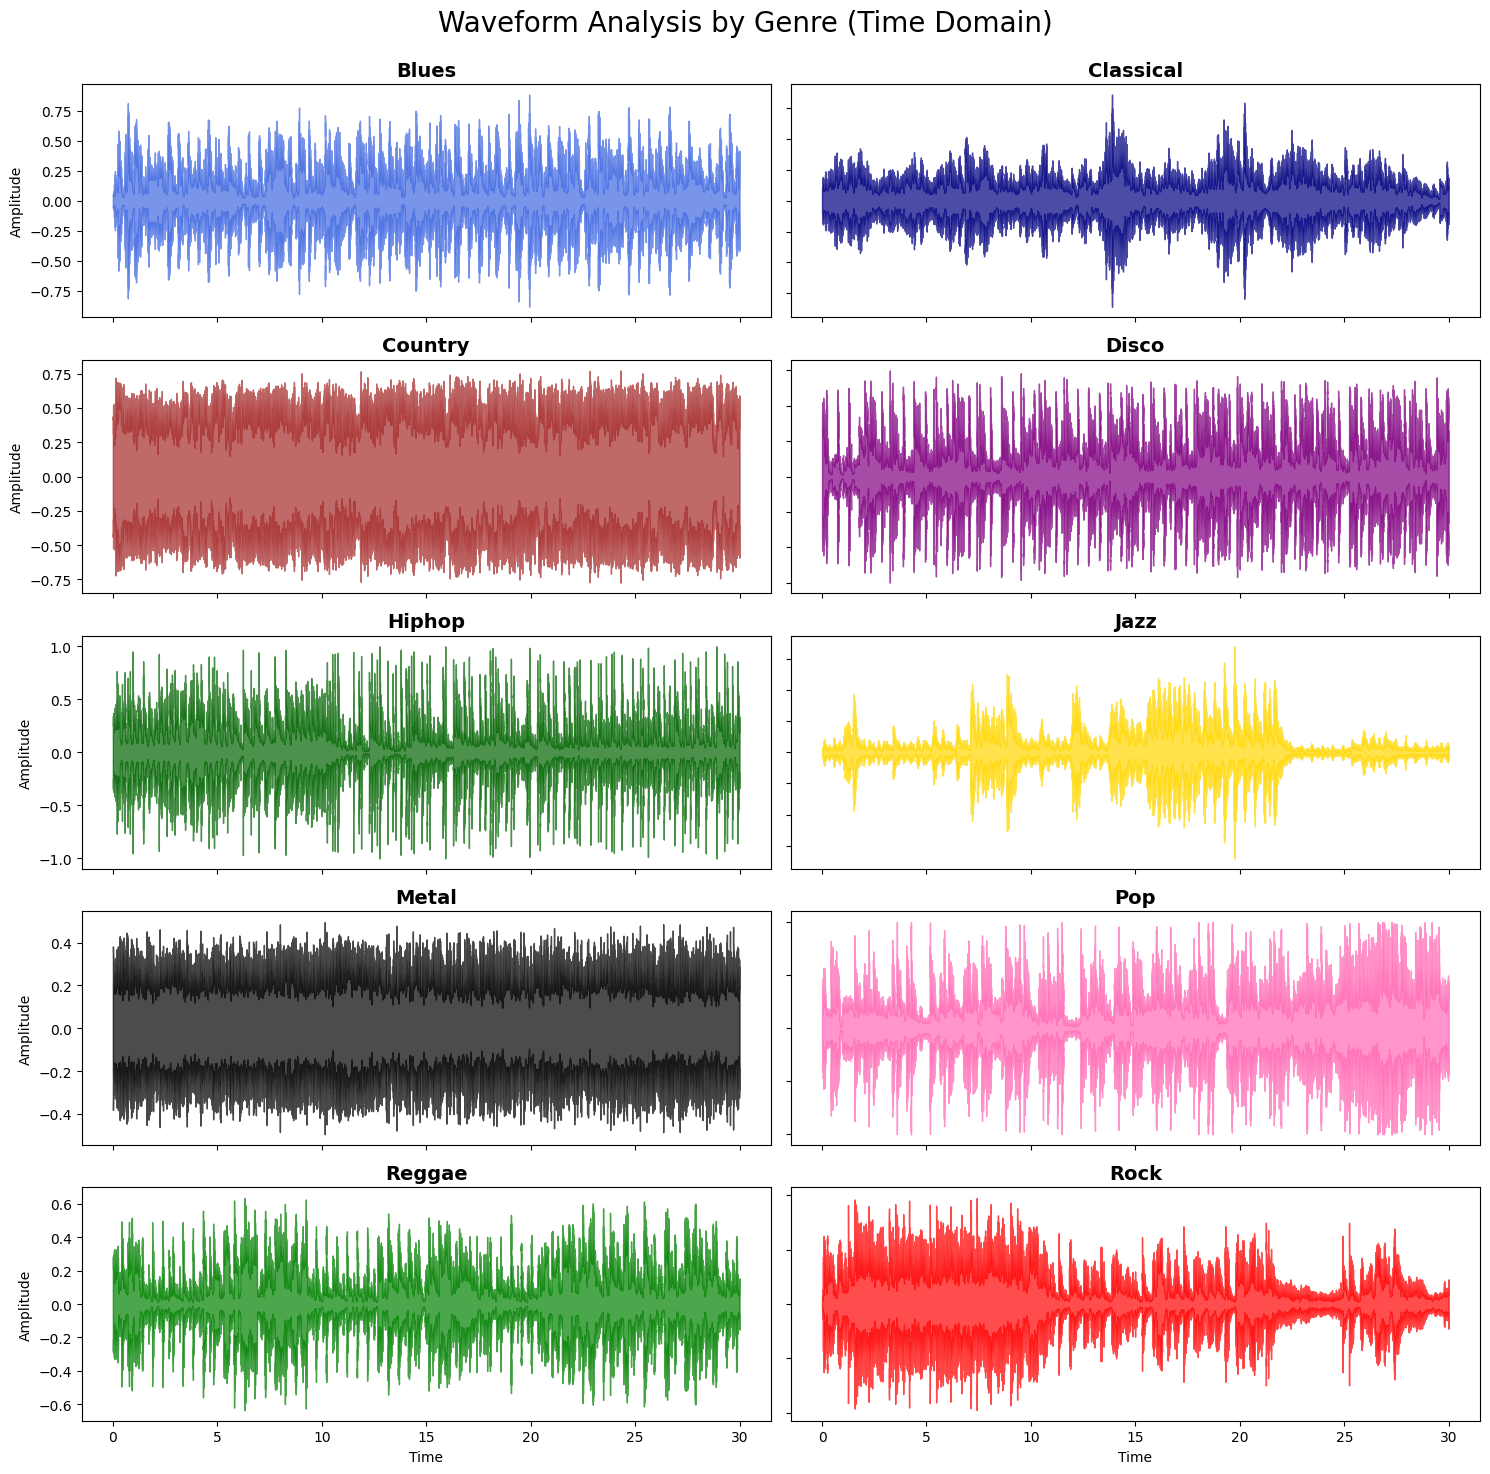

In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

#  Data Dictionary
genres = {
    'Blues':    ('Data/genres_original/blues/blues.00000.wav', 'royalblue'),
    'Classical':('Data/genres_original/classical/classical.00000.wav', 'navy'),
    'Country':  ('Data/genres_original/country/country.00000.wav', 'brown'),
    'Disco':    ('Data/genres_original/disco/disco.00000.wav', 'purple'),
    'Hiphop':   ('Data/genres_original/hiphop/hiphop.00000.wav', 'darkgreen'),
    'Jazz':     ('Data/genres_original/jazz/jazz.00000.wav', 'gold'),
    'Metal':    ('Data/genres_original/metal/metal.00000.wav', 'black'),
    'Pop':      ('Data/genres_original/pop/pop.00000.wav', 'hotpink'),
    'Reggae':   ('Data/genres_original/reggae/reggae.00000.wav', 'green'),
    'Rock':     ('Data/genres_original/rock/rock.00000.wav', 'red')
}

# Init plot grid
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
fig.suptitle('Waveform Analysis by Genre (Time Domain)', fontsize=20)
axes = axes.flatten()

# Loop to generate plots
for i, (genre, (path, color)) in enumerate(genres.items()):
    # loading audio
    y, sr = librosa.load(path, duration=30)

    # plotting
    librosa.display.waveshow(y, sr=sr, alpha=0.7, color=color, ax=axes[i])
    axes[i].set_title(f'{genre}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Amplitude')
    axes[i].label_outer()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

Interestingly enough all the genres look different! We should be able to create effective model for genre classification.

## Spectograms

Finally I'm going to visually inspect Spectograms (part of the dataset). It's another way to look at the differences between the genres.

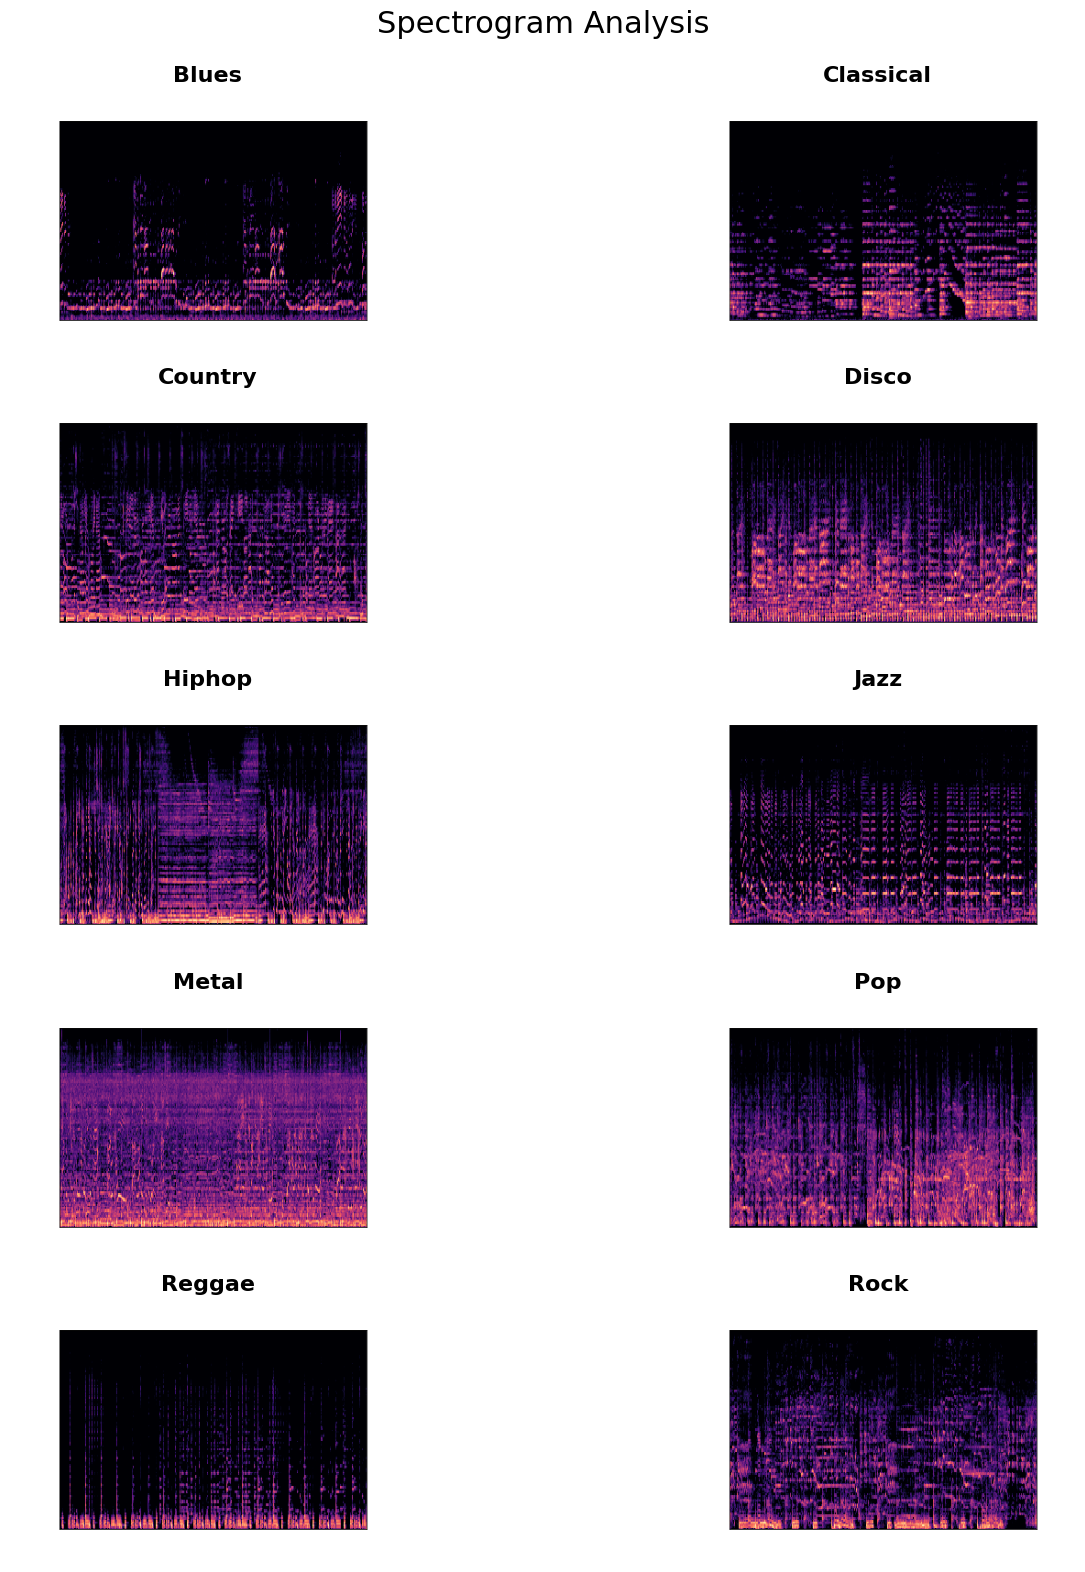

In [8]:
import matplotlib.image as mpimg

base_image_dir = 'Data/images_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Init grid
fig, axes = plt.subplots(5, 2, figsize=(16, 16))
fig.suptitle('Spectrogram Analysis', fontsize=22)
axes = axes.flatten()

# Loop through genres
for i, genre in enumerate(genres):
  genre_folder = os.path.join(base_image_dir, genre)

  # Visualiing just the first file per genre
  image_files = os.listdir(genre_folder)
  first_image = image_files[0]
  full_path = os.path.join(genre_folder, first_image)
  img = mpimg.imread(full_path)
  axes[i].imshow(img)

  # Styling
  axes[i].set_title(genre.capitalize(), fontsize=16, fontweight='bold')
  axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.93) # Make room for the main title
plt.show()

Similarily to the waveform visualization there are differences between genres, although between some they seem subtle (Reggae and Rock). Nevertheless a CNN should be able to deal with this.

## Data normalization and preparation

Based on the EAD - I need to prepare the data for training by scaling it. Before we go into it, I'm going to split the data into test and training.

### Splitting data into train and test

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separating Features and target values
# I'm dropping filename, length and label from X
X = df.drop(['filename', 'length', 'label'], axis=1)
y = df['label']

# Encodeing labels (String -> Integer) for the algorithmic work
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Print the mapping
print("Label Mapping:")
for index, label in enumerate(encoder.classes_):
    print(f"{index}: {label}")

# Splitting the data (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData Split Complete.")
print(f"Training set: {X_train_raw.shape}")
print(f"Test set: {X_test_raw.shape}")

Label Mapping:
0: blues
1: classical
2: country
3: disco
4: hiphop
5: jazz
6: metal
7: pop
8: reggae
9: rock

Data Split Complete.
Training set: (800, 57)
Test set: (200, 57)


### Normalization / scaling of data

As seen in the EDA, features like 'Tempo' (approx 120) and 'RMS' (approx 0.1) have vastly different ranges. We use StandardScaler to normalize inputs to mean 0 and variance 1, ensuring the Neural Network converges faster.

In [11]:
from sklearn.preprocessing import StandardScaler

# Init scaler
scaler = StandardScaler()

# Fitting on Training Data ONLY
scaler.fit(X_train_raw)

# Transform both training and test data
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Verification
print("Before Scaling (Raw Example):", X_train_raw.iloc[0, 0])
print("After Scaling (Normalized Example):", X_train[0, 0])

print("\nMean of Training Set (should be ~0):", round(X_train.mean(), 2))
print("Std Dev of Training Set (should be ~1):", round(X_train.std(), 2))

Before Scaling (Raw Example): 0.2936961948871612
After Scaling (Normalized Example): -1.0474407842289586

Mean of Training Set (should be ~0): -0.0
Std Dev of Training Set (should be ~1): 1.0


## Model Analysis and training

The dataset provides a nice range of different data modalities, which will let me compare a multilayer perceptron (training based on numerical values) to a CNN deep learning neural net.

In a way the perceptron is going to serve as a baseline to compare the CNN to.

### Multilayer Perceptron - training

I will use Keras (TensorFlow) to build a simple multilayer perceptron with the current architecture:
* Input - 57 scaled features (60 original csv columns less the three that I dropped earlier).
* Hidden Layers - Two layers with ReLU activation
* Output: 10 neurons (one per genre) with softmax to give probability.



In [12]:
import tensorflow as tf
from tensorflow.keras import models, layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Network Architecture
model_mlp = models.Sequential([
    # Input Layer: 57 features (shape of X_train columns from CSV)
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),

    # Output Layer: 10 neurons (one per genre)
    layers.Dense(10, activation='softmax')
])

# Model compilation
model_mlp.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the Model
print("Starting training for Model A (Baseline)...")
history = model_mlp.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

Num GPUs Available:  1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training for Model A (Baseline)...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1697 - loss: 2.2639 - val_accuracy: 0.4050 - val_loss: 1.7440
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3749 - loss: 1.7093 - val_accuracy: 0.5250 - val_loss: 1.3805
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4995 - loss: 1.3971 - val_accuracy: 0.5800 - val_loss: 1.1585
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5670 - loss: 1.1909 - val_accuracy: 0.6650 - val_loss: 1.0382
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6665 - loss: 1.0136 - val_accuracy: 0.6750 - val_loss: 0.9577
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6534 - loss: 0.9468 - val_accuracy: 0.7150 - val_loss: 0.8999
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6948 - loss: 0.8626 - val_accuracy: 0.7000 - val_loss: 0.9151
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7252 - lo

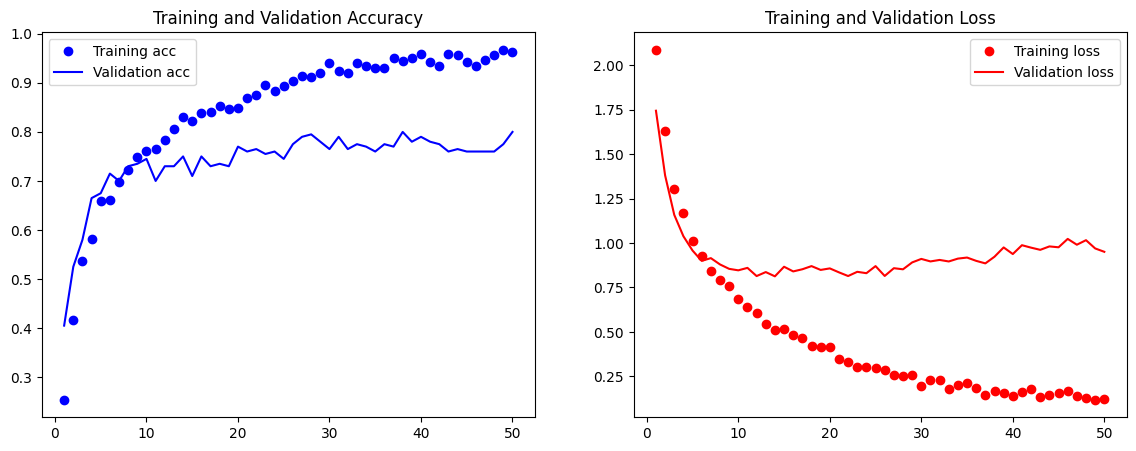

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7880 - loss: 1.1035 

Baseline MLP Test Accuracy: 80.00%


In [13]:
# Plotting  history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)
test_loss, test_acc = model_mlp.evaluate(X_test, y_test)
print(f"\nBaseline MLP Test Accuracy: {test_acc*100:.2f}%")

### Multilayer perceptron - results overview

The multlayer perceptron converged with the accuracy of 98% on the training set, however the accuract of the test set cllapsed from the peak of the 10th epoch, and flattened out at about 75-80% accuracy. Starting from about the 20th epoch the validation loss started to gradually increase.

This data points out at significant overfitting of the perceptron. It's likely caused by the fact that the dataset is relativelly small (after our split, just 800 songs in the training set). The perceptron is overpowering, and memorizes all the data patterns. CNN should do much better.

### Evaluation of Multilayer perceptron

| Metric | Result |
| :--- | :--- |
| **Final Test Accuracy** | **80.00%** |
| **Peak Training Accuracy** | **~98%** (at epoch 50) |
| **Peak Validation Accuracy** | **~80%** (stalled after epoch 20) |


### Convolutional Neural Network - model training

Now, I'm going to try a completely different approach to the problem. Instead of finding patterns in the numerical data, I'll define a CNN network looking for patterns in spectograms (mel-spectograms to be precise). CNN should be able to learn to recognize the visual aspects of Heavy Metal distortion versus the clean vertical lines of a Disco beat and lead to greater accuracy of the classification.

The creation of the CNN will follow two steps:
1. I'll process the images in preparation for the training (defining dimensions, splitting trainign and validation, and defining caching)
2. I'll define the architecture of the model and trigger training

#### Reference

Doshi, K. (2021, February 19). Audio deep learning made simple – Why mel spectrograms perform better. Ketan Doshi. https://ketanhdoshi.github.io/Audio-Mel/


#### Convolutional Neural Network - image loading and processing

Below I'm defining the dimension and batching of the images, dividing the whole set into training and validation, and introducing a light caching to optimize performance.

In [14]:
# Config
img_height = 256
img_width = 256
batch_size = 32
data_dir = 'Data/images_original' # Make sure this matches your folder name

# Training data (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation data (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Cache data in memory so it trains faster
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Image Data Loaded!")

Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.
Image Data Loaded!


### Convolutional Neural Network - architecture and training

The architecutre of my CNN is similar to what we've discussed during the MSAI course:
* 3 layers of Conv2D: scaning the image for features each with Maxpooling (compressing the image to focus on the most important features).
* Flatten: Converting the 2D image maps into a 1D list of numbers.
* Dense layer: classifier layer with relu activation and a dropout to prevente overfitting, followed by another dense layer with softamx to get probabilities

In [15]:
num_classes = 10

model_cnn = models.Sequential([
  # Rescale pixels from 0-255 to 0-1
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # First convolutional layer - simple features
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Second conv – more complex features
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Third conv - abstract concepts
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  # Classifier
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,882 (64.36 MB)

 Trainable params: 16,871,882 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Trigger training

print("Starting CNN Training...")
history_cnn = model_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Starting CNN Training...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.1279 - loss: 3.3725 - val_accuracy: 0.2362 - val_loss: 2.2208
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.2232 - loss: 2.1646 - val_accuracy: 0.2915 - val_loss: 2.0630
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3022 - loss: 1.9651 - val_accuracy: 0.3266 - val_loss: 1.8506
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3759 - loss: 1.7275 - val_accuracy: 0.4472 - val_loss: 1.6218
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4162 - loss: 1.5761 - val_accuracy: 0.4573 - val_loss: 1.5611
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5029 - loss: 1.3616 - val_accuracy: 0.4171 - val_loss: 1.5472
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5959 - loss: 1.2065 - val_accuracy: 0.5126 - val_loss: 1.4078
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6889 - loss: 0.9185

In [17]:
print("Evaluating CNN Model...")
val_loss, val_acc = model_cnn.evaluate(val_ds)
print(f"\nFINAL CNN VALIDATION ACCURACY: {val_acc*100:.2f}%")

Evaluating CNN Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5139 - loss: 2.9245

FINAL CNN VALIDATION ACCURACY: 50.75%


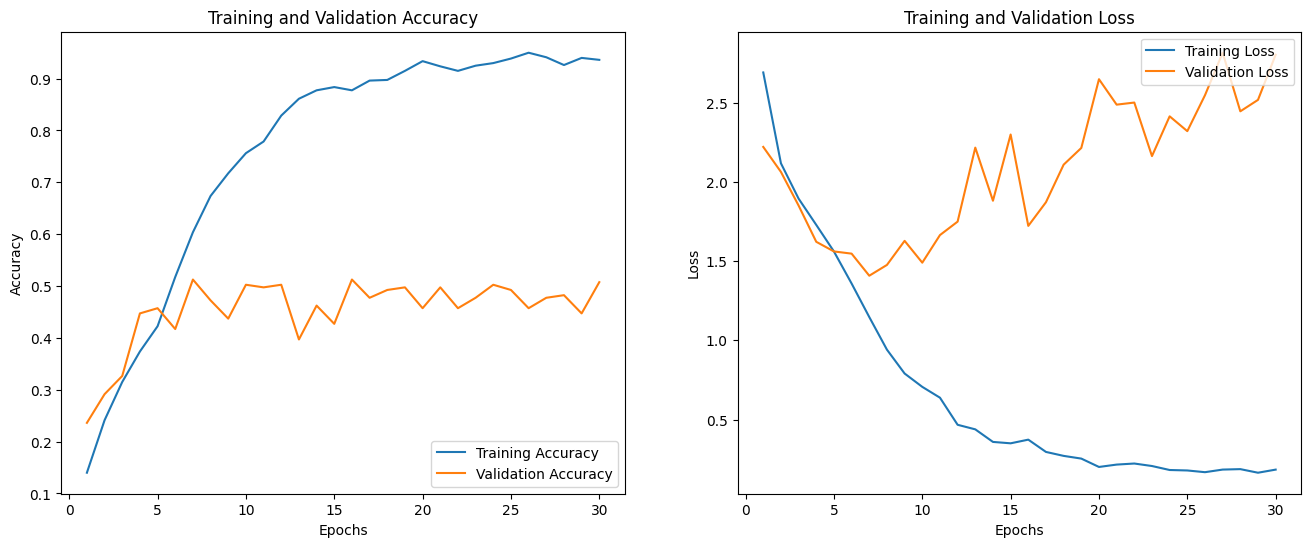

In [33]:
import matplotlib.pyplot as plt

# Extracting data
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### Convolutional Neural Network - results overview

Unfortunately my model didn't performerm very well. Similarily to my multilayer perceptron CNN started overfitting (well visibly on the accuracy and validation loss plots). The overall accuracy ended up being relatively low for the test set – just 50.75%.

The dataset, again, maybe just too small for the task.

To recover from this failure I'll try a different approach next.

### CNN optimization with transfer learning

To overcome the overfitting caused by small dataset, I did a research on different CNN optimization approaches and I've learned that transfer learning may save the day.

Transfer Learning is a technique where a model developed for a task on a big dataset is reused as the starting point for a model on a second task. Instead of training a network from scratch with random weights, I'm going to utilize MobileNetV2, a model pre-trained on ImageNet (14 million images). The hypothesis is that the "visual knowledge" MobileNetV2 has e.g. how to detect edges, curves, textures, and complex geometric patterns, will improve my CNN for more complex images.


#### References
Weirich, A. (2024, June 18). Transfer learning with Keras/TensorFlow: An introduction. Medium. https://medium.com/@alfred.weirich/transfer-learning-with-keras-tensorflow-an-introduction-51d2766c30ca

Weirich, A. (2024, July 4). Finetuning TensorFlow/Keras networks: Basics using MobileNetV2 as an example. Medium. https://medium.com/@alfred.weirich/finetuning-tensorflow-keras-networks-basics-using-mobilenetv2-as-an-example-8274859dc232

In [18]:
from tensorflow.keras import applications

# Loading the Pre-Trained Model (MobileNetV2)
base_model = applications.MobileNetV2(input_shape=(256, 256, 3),
                                      include_top=False,
                                      weights='imagenet')
base_model.trainable = False

# Building the Transfer Learning Model
model_transfer = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compiling
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_transfer.summary()

# Training
print("Starting Transfer Learning...")
history_transfer = model_transfer.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

/tmp/ipython-input-32902760.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=(256, 256, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting Transfer Learning...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 684ms/step - accuracy: 0.1183 - loss: 2.7943 - val_accuracy: 0.4171 - val_loss: 1.7652
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3223 - loss: 1.9437 - val_accuracy: 0.5377 - val_loss: 1.4540
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4204 - loss: 1.6465 - val_accuracy: 0.5578 - val_loss: 1.3439
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5148 - loss: 1.3736 - val_accuracy: 0.5879 - val_loss: 1.3325
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5367 - loss: 1.3081 - val_accuracy: 0.5829 - val_loss: 1.2728
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5503 - loss: 1.2806 - val_accuracy: 0.6080 - val_loss: 1.2342
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5954 - loss: 1.1887 - val_accuracy: 0.5980 - val_loss: 1.2299
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5991 - loss: 1

In [19]:
print("Evaluating Transfer Model...")
val_loss, val_acc = model_transfer.evaluate(val_ds)
print(f"\nFINAL TRANSFER VALIDATION ACCURACY: {val_acc*100:.2f}%")

Evaluating Transfer Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6397 - loss: 1.0975

FINAL TRANSFER VALIDATION ACCURACY: 62.81%


### CNN optimization with transfer learning - results overiew

Unfortunately transfer learning didn't generate results that I was hoping for. While 62.81% accuracy is an improvement, it's still far below the multilayer perceptron. The combination of the impact of a small dataset and likely the domain-mismatch in the MobileNetV2 led to a result even worse than my original CNN. MobileNet is pre-trained on ImageNet ( photography). The visual features of a physical object (e.g. the edge of a table) may not translate effectively to spectrograms.

Next, I'll try to directly address the problem of lack of data with a little bit of data engineering.

### CNN optimization with data slicing

Since the transfer learning turns out to be another failure, likely due to the too small dataset, I decided to give a try to a different method and... multiply the data by slicing it into 3s chunks (instead of 30s). This will 10x my dataset and hopefully lead to a drastically more performant CNN.

In [20]:
from tensorflow.keras.utils import to_categorical

# Config
DATA_PATH = 'Data/genres_original'
GENRES = genres
start_stop_seconds = 30
slice_duration = 3 #
samples_per_slice = 22050 * slice_duration # 22050Hz * 3 seconds

def process_data(data_path):
    X = [] # Spectrograms
    y = [] # Labels

    print("Processing audio files (This will take a few minutes)...")

    for i, genre in enumerate(GENRES):
        print(f"  Working on {genre}...")
        genre_path = os.path.join(data_path, genre)

        for filename in os.listdir(genre_path):
            file_path = os.path.join(genre_path, filename)
            try:
                # Loading full 30s file
                signal, sample_rate = librosa.load(file_path, duration=30)

                # 10 slices per track
                num_slices = int(start_stop_seconds / slice_duration)

                for s in range(num_slices):
                    start_sample = samples_per_slice * s
                    end_sample = start_sample + samples_per_slice

                    if len(signal[start_sample:end_sample]) == samples_per_slice:
                        slice_signal = signal[start_sample:end_sample]

                        # Generate MFCC (Spectrogram-like feature)
                        mfcc = librosa.feature.mfcc(y=slice_signal, sr=sample_rate, n_mfcc=13)

                        # Transpose to get (Time, Feats) shape
                        mfcc = mfcc.T

                        X.append(mfcc)
                        y.append(i)
            except Exception as e:
                pass

    return np.array(X), np.array(y)

# Running the Processing
X_data, y_data = process_data(DATA_PATH)

# Reshape for CNN (Add the "Channel" dimension)
# Shape becomes: (10000, 130, 13, 1)
X_data = X_data[..., np.newaxis]

# Creating Labels
y_data = to_categorical(y_data, num_classes=10)

# Split Data (80/20)
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f"\nSuccess! New Dataset Size: {X_train_aug.shape[0]} training samples (was 800)")
print(f"Input Shape: {X_train_aug.shape[1:]}")

Processing audio files (This will take a few minutes)...
  Working on blues...
  Working on classical...
  Working on country...
  Working on disco...
  Working on hiphop...
  Working on jazz...


/tmp/ipython-input-789869762.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Working on metal...
  Working on pop...
  Working on reggae...
  Working on rock...

Success! New Dataset Size: 7984 training samples (was 800)
Input Shape: (130, 13, 1)


In [21]:
from tensorflow.keras import optimizers

# New augmented model
model_aug = models.Sequential([

    # Input Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_aug.shape[1], X_train_aug.shape[2], 1)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(), # Helps training stabilize

    # Deep Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),

    # Deep Block 2
    layers.Conv2D(32, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),

    # Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3), # Still need dropout, but less aggressive

    layers.Dense(10, activation='softmax')
])

# Adam with lower learning rate
optimizer = optimizers.Adam(learning_rate=0.0001)

model_aug.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_aug.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

In [22]:
print("Starting training...")
history_aug = model_aug.fit(X_train_aug, y_train_aug,
                    validation_data=(X_test_aug, y_test_aug),
                    batch_size=32,
                    epochs=50)

Starting training...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1794 - loss: 2.6372 - val_accuracy: 0.3791 - val_loss: 1.7762
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3475 - loss: 1.8923 - val_accuracy: 0.4517 - val_loss: 1.5463
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4175 - loss: 1.6507 - val_accuracy: 0.5028 - val_loss: 1.3935
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4660 - loss: 1.5018 - val_accuracy: 0.5408 - val_loss: 1.2816
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4916 - loss: 1.4064 - val_accuracy: 0.5764 - val_loss: 1.2034
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5296 - loss: 1.3076 - val_accuracy: 0.5914 - val_loss: 1.1509
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5441 - loss: 1.2437 - val_accuracy: 0.6179 - val_loss: 1.0924
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5642 - loss: 1.

In [23]:
print("Evaluating Augmented CNN Model...")
test_loss, test_acc = model_aug.evaluate(X_test_aug, y_test_aug)

print(f"\nFINAL AUGMENTED CNN ACCURACY: {test_acc*100:.2f}%")

Evaluating Augmented CNN Model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.6590

FINAL AUGMENTED CNN ACCURACY: 77.17%


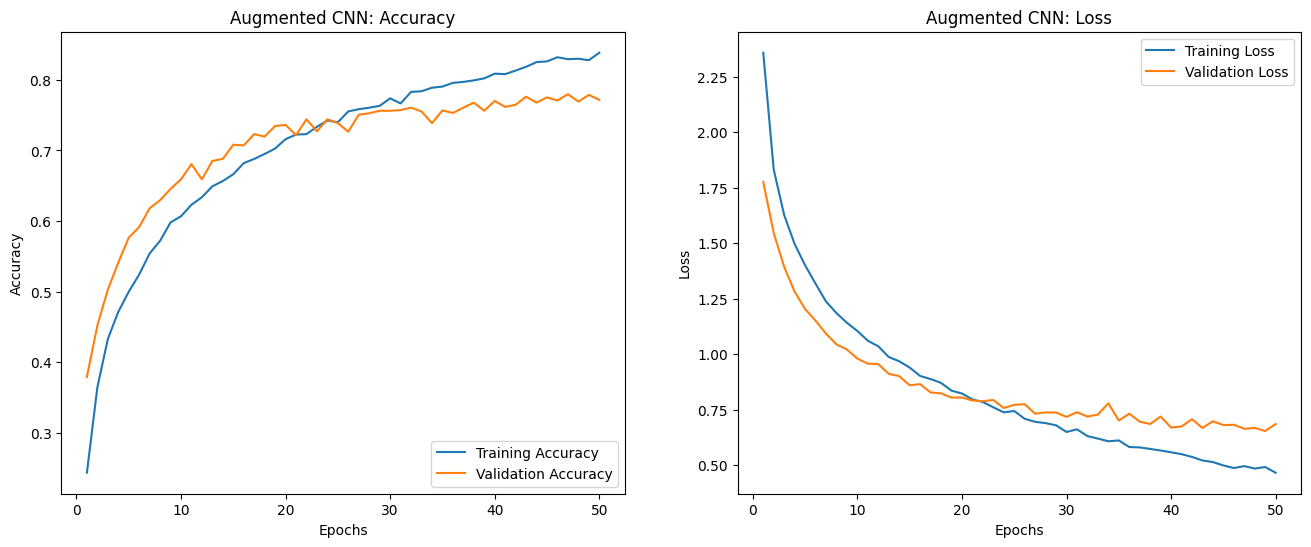

In [24]:
# Geting history
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmented CNN: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmented CNN: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### CNN optimization with data slicing - results overview

Data slicing resulted in much better results. The model stopped overfitting and landed at 77.17% accuracy for the validation set. While this is still below the multilayer perceptron, ultimately the model is more stable, converges better and is not overfitting.

At this point though I started to feel very ambitious. My EAD was clearly showing fairly clear differences in spectograms, so why the CNN can't perform even better than 77% accuracy? I decided to do more research and find some different optimization technique.

### CNN optimization with ResNet

Looking at my prior attempts I started to realise that the lack of data had an impact on the learning process in two ways. First of all, I suppose with small number of observations my models started to memorize early features quickly and failed at lower levels of abstraction. Each batch had probably a high variance so the gradient was bouncing around quite a bit and getting stuck. Increasing the size of the dataset helped with this issue, but I still suffered from the vanishing gradient - the learning signal starts disappering in the chain rule and the impact on learning is very small.

Researching this issue directed me to ResNet architecture and I decided to give it a try. Unlike a classic CNN, ResNet  avoids disappearing gradient from the early layers, and introduces a shortcut, a skip connection, that directs information directly to the output.

I also decided to add a learning rate scheduler to further stabilize training and maximize accuracy. Deep networks often struggle to converge on the global minimum when using a fixed learning rate; they tend to oscillate around the target loss value because the gradient updates are too large for finetuning. I'm going to start with a relatively high learning rate for the initial 10 epochs to quickly learn dominant features (such as tempo and spectral centroid), and then the learning rate is decrease by 5% per epoch. This strategy should let the model settle on a global minimum without overshooting.

#### Reference
GeeksforGeeks. (2024). *Residual Networks (ResNet) – Deep Learning*. Retrieved from [https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/](https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/)

Sharma, T. (2024, May 6). *Detailed Explanation of Residual Network (ResNet50) CNN Model*. Medium. Retrieved from [https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e](https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e)

In [29]:
from tensorflow.keras import callbacks, regularizers

# Learning Rate Scheduler
# This callback reduces the learning rate (step size) by 5% every 10 epochs
# This allows the model to settle precisely on the best accuracy.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        # Reduces the learning rate by 5% after the 10th epoch
        return lr * 0.95

lr_callback = callbacks.LearningRateScheduler(scheduler)

# ResNet-Style Architecture (Functional API)
# Input Shape: (130 timesteps, 13 MFCC features, 1 channel)
input_shape = (X_train_aug.shape[1], X_train_aug.shape[2], 1)
inputs = layers.Input(shape=input_shape)

# Initial Layer
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, padding='same')(x)

# Residual Block 1 (The core change)
res = x
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, res]) # Add the shortcut connection back
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)

# Residual Block 2
res = layers.Conv2D(64, 1, strides=1, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, res])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)

# Classification Head
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_resnet = models.Model(inputs=inputs, outputs=outputs)

In [31]:
optimizer = optimizers.Adam(learning_rate=0.001)

model_resnet.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resnet.summary()

print("\nStarting Final High-Performance Training...")
history_resnet = model_resnet.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test_aug, y_test_aug),
    batch_size=32,
    epochs=60,
    callbacks=[lr_callback]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 130, 13,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 130, 13,   │        320 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 13,   │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 65, 7, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 65, 7, 32) │      9,248 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 7, 32) │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 65, 7, 32) │      9,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 7, 32) │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 65, 7, 32) │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 65, 7, 32) │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 33, 4, 32) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 33, 4, 64) │     18,496 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 4, 64) │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 33, 4, 64) │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 4, 64) │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 33, 4, 64) │      2,112 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 33, 4, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 33, 4, 64) │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 217,226 (848.54 KB)

 Trainable params: 216,778 (846.79 KB)

 Non-trainable params: 448 (1.75 KB)


Starting Final High-Performance Training...
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3488 - loss: 1.9019 - val_accuracy: 0.5553 - val_loss: 1.3030 - learning_rate: 0.0010
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4640 - loss: 1.5091 - val_accuracy: 0.5704 - val_loss: 1.2797 - learning_rate: 0.0010
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5191 - loss: 1.3669 - val_accuracy: 0.6254 - val_loss: 1.0728 - learning_rate: 0.0010
Epoch 4/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5884 - loss: 1.1971 - val_accuracy: 0.6810 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 5/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6345 - loss: 1.1145 - val_accuracy: 0.6760 - val_loss: 1.0464 - learning_rate: 0.0010
Epoch 6/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6612 - loss: 1.0037 - val_accuracy: 0.7056 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 7/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 1

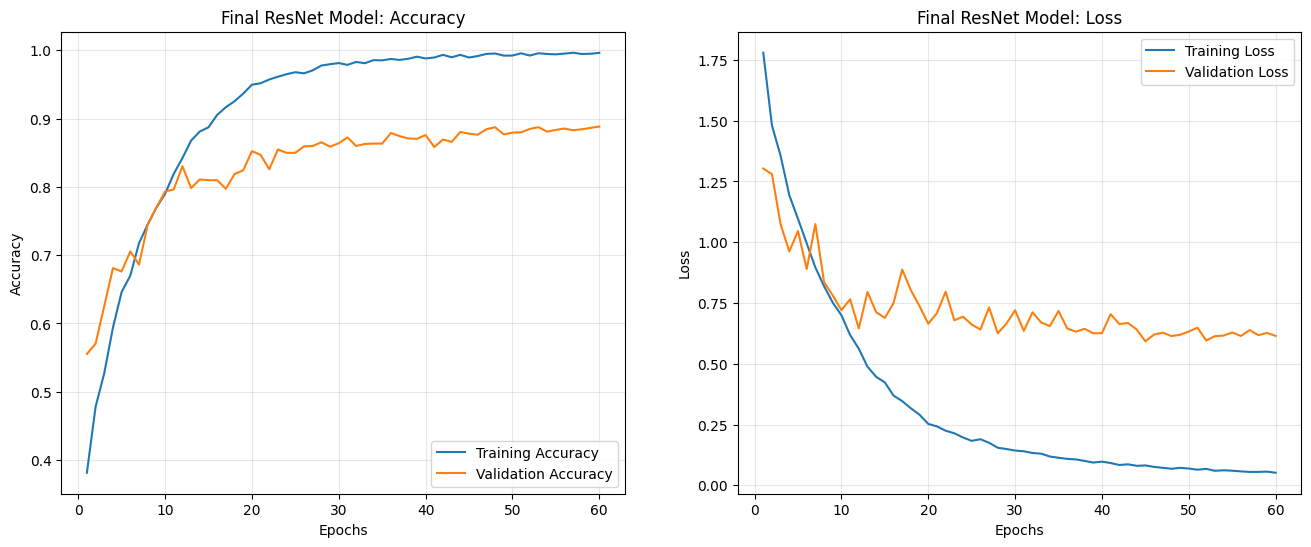

Evaluating Final ResNet Model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8953 - loss: 0.5975
FINAL TEST ACCURACY: 88.83%


In [32]:
import matplotlib.pyplot as plt

# Data from the ResNet History
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Final ResNet Model: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3) # Grid makes it easier to read the exact %

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Final ResNet Model: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.show()

# 3. Final Evaluation
print("Evaluating Final ResNet Model...")
test_loss, test_acc = model_resnet.evaluate(X_test_aug, y_test_aug)

print(f"FINAL TEST ACCURACY: {test_acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


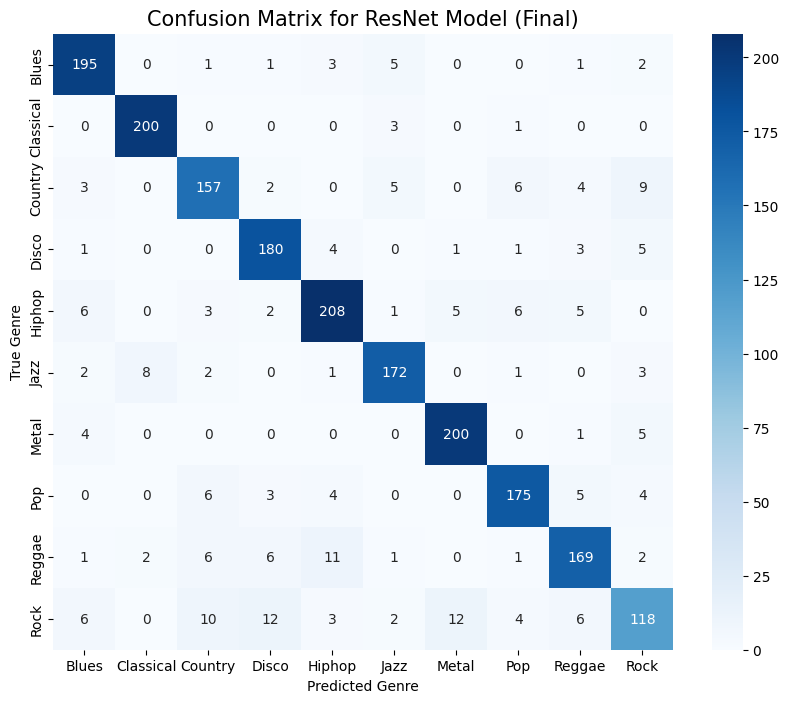

In [34]:
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_probs = model_resnet.predict(X_test_aug)

# Converting probs to single integer class labels (0-9)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Converting one-hot encoded true labels back to single integer class labels
y_true_classes = np.argmax(y_test_aug, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[g.capitalize() for g in genres],
            yticklabels=[g.capitalize() for g in genres])

plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix for ResNet Model (Final)', fontsize=15)
plt.show()

### CNN optimization with ResNet - results overview

The results of ResNet ended up being significantly better! 88.83% accuracy on the test data was a lot better than my prior CNNs.

Residual Connections allowed the network to be deeper without suffering from the vanishing gradient problem, enabling it to learn complex hierarchical features.

The Learning Rate Scheduler allowed the model to fine-tune its weights precisely, resulting in the smooth 'landing' observed in the loss curves.

I kept it out of notebook for clarity, but I also did a few experiments with learning rate value. A very small learning rate  (0.00001) was actually hurting the performance of the model, and when I increased it to 0.001 I got to the optimal result!

Confusion matrix also offered interesting insights - rock is the most confusing genre for the model. Likely because it represents such a broad range of musical expression.

## Project Conclusion & Discussion

In this project I went through... a lot. First of all I've learned about the optimization problems of CNN and its dependency on both the size of the dataset, and the depth of the network (vanishing gradient). It was fascinating to observe how different optimization methods lead to different results. ResNet architecture proved to be an incredible tool, especially when paired with a decaying learning rate built-in via scheduler callback.

| Model Phase | Accuracy | Key Finding |
| :--- | :--- | :--- |
| **Multilayer perceptron** | **80.00%** | Proved that mathematical features (Tempo, RMS, MFCCs) contain significant predictive power. |
| **First CNN** | **50.75%** | Really bad performance due to small data set and lack of optimization |
| **Transfer Learning** | **62.81%** | Confirmed that the "Small Data" problem (1,000 images) and domain mismatch (photos vs. spectrograms) caused severe overfitting. |
| **Sliced data CNN** | **77.17%** | Showed the potential of a CNN running with a larger dataset |
| **ResNet** | **88.83%** | The combination of data Aagmentation (10x samples) and the ResNet architecture (solving the Vanishing Gradient problem) allowed the model to successfully learn deep patterns, decisively beating the baseline. |

### Potential improvements

1. Ensemble model - it was interesting to see how a simple multilayer perceptron can offer powerful predicitons. Combining it with the ResNet model into one architecture could be an interesting approach. I don't know how to do it, but I've read about ensemble models and it seems that it could be possible.

2. ResNet finetuning - apart from tuning the learning rate and the scheduler I left ResNet pretty much stock, further finetuning could likely lead to even greater results.

3. More data and more advanced augmentation - CNNs are clearly data hungry. having more, and more robust, observations would grately improve the efficiency of the model. It could also be beneficial to play around with more advanced augmentation e.g. by randomly modifying the spectrum (to prevent overfitting)